In [1]:
import numpy as np
import pickle
from astropy.io import fits
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
import gd1_util
import GMC_util


Populating the interactive namespace from numpy and matplotlib


### Test whether very old impacts are important. To do this, we will impact a mock GD-1 stream by subhalos at ~7 Gyr and compute the density today.

In [2]:
ro=8.
vo=220.

def parse_times(times,age,ro,vo):
    if 'sampling' in times:
        nsam= int(times.split('sampling')[0])
        return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*age]
    return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
            for ti in times.split(',')]
            
timpacts= parse_times('6.,6.5,7.,7.5,8.,8.5',9.,ro=ro,vo=vo)

print (np.array(timpacts)*bovy_conversion.time_in_Gyr(vo,ro))

[6.  6.5 7.  7.5 8.  8.5]


In [ ]:
pepperfilename='GD1_oldimpactstest_MW2014_leadingarm.pkl'
sdf_pepper= gd1_util.setup_gd1model(timpact=timpacts)
save_pickles(pepperfilename,sdf_pepper)

In [114]:
with open('GD1_oldimpactstest_MW2014_leadingarm.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

In [4]:
sdf_smooth=gd1_util.setup_gd1model()

In [115]:
apar_full,x_full,y_full,z_full,vx_full,vy_full,vz_full = GMC_util.aparxv_stream(sdf_smooth,sdf_pepper)


In [109]:
print (sdf_pepper._timpact*bovy_conversion.time_in_Gyr(vo,ro))

[6.  6.5 7.  7.5 8.  8.5]


In [116]:
apar_imp=apar_full[0][10]
v_imp=np.c_[vx_full[0][10],vy_full[0][10],vz_full[0][10]+0.00001]
M_imp=10**9./bovy_conversion.mass_in_msol(vo,ro)
timp=sdf_pepper._timpact[0]

def rs(M):
    return 1.05*(M/10**8.)**(0.5)

rs_imp=rs(10**9.)/8.

print (rs_imp)

print (v_imp)

0.4150489428970998
[[ 0.46794216  0.35429    -0.07144899]]


In [117]:
#import streampepperdf

sdf_pepper.set_impacts(impactb=[0.1/8.],subhalovel=v_imp,impact_angle=[apar_imp],timpact=[timp],rs=[rs_imp],GM=[M_imp])



In [118]:
apar=np.linspace(0.03,1.14,100)

dens_unp=[]
dens=[]
omega_unp=[]
omega=[]

for a in apar :
    dens_unp.append(sdf_smooth._density_par(a))
    omega_unp.append(sdf_smooth.meanOmega(a,oned=True))
    dens.append(sdf_pepper._densityAndOmega_par_approx(a)[0])
    omega.append(sdf_pepper._densityAndOmega_par_approx(a)[1])
    

dens_unp=np.array(dens_unp)
dens=np.array(dens)
omega=np.array(omega)

In [119]:
print (dens)

[1.00000914e+00 1.00000914e+00 1.00000913e+00 1.00000912e+00
 1.00000910e+00 1.00000906e+00 1.00000900e+00 1.00000890e+00
 1.00000873e+00 1.00000845e+00 1.00000800e+00 1.00000728e+00
 1.00000612e+00 1.00000430e+00 1.00000147e+00 9.99997089e-01
 9.99990397e-01 9.99980272e-01 9.99965106e-01 9.99942619e-01
 9.99909610e-01 9.99861644e-01 9.99792645e-01 9.99694385e-01
 9.99555864e-01 9.99362545e-01 9.99095463e-01 9.98730181e-01
 9.98235613e-01 9.97572729e-01 9.96693176e-01 9.95537860e-01
 9.94035572e-01 9.92101738e-01 9.89637407e-01 9.86528610e-01
 9.82646217e-01 9.77846447e-01 9.71972164e-01 9.64855064e-01
 9.56318855e-01 9.46183461e-01 9.34270218e-01 9.20407992e-01
 9.04440021e-01 8.86231270e-01 8.65675948e-01 8.42704831e-01
 8.17291964e-01 7.89460317e-01 7.59285972e-01 7.26900479e-01
 6.92491098e-01 6.56298736e-01 6.18613547e-01 5.79768274e-01
 5.40129579e-01 5.00087719e-01 4.60045068e-01 4.20404019e-01
 3.81554904e-01 3.43864496e-01 3.07665689e-01 2.73248818e-01
 2.40854995e-01 2.106716

In [120]:
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    outll= numpy.linspace(numpy.amin(mT[0]),numpy.amax(mT[0]),len(apars))
    #phi12=lb_to_phi12(mT[0],mT[1],degree=True)
    #print (phi12[:,0])
    
    pp= Polynomial.fit(apars,dens,deg=3)
    outphi1= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))

ll,dd=convert_dens_to_obs(apar,dens,dens_unp,omega)
    

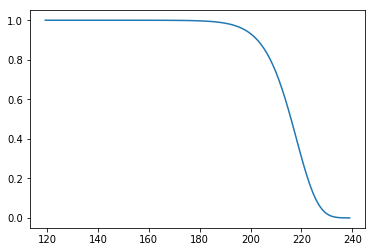

In [121]:
plt.figure()
plt.plot(ll,dd)
plt.show()